# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier


In [1]:
import cv2
import math
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pandas as pd
import pickle
import pylab
import time
import tensorflow as tf

from matplotlib.pyplot import *
from PIL import Image
from pprint import pprint
from sklearn.utils import shuffle

# Visualizations will be shown in the notebook.
%matplotlib inline

---
## Step 0: Load The Data

In [2]:
training_file = 'train.p'
validation_file='valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train_ini, y_train = train['features'], train['labels']
X_validation_ini, y_validation = valid['features'], valid['labels']
X_test_ini, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**


### Basic Summary of the Data Set

In [3]:
# Number of training examples
n_train = len(X_train_ini)

# Number of testing examples.
n_test = len(y_test)

# What's the shape of an traffic sign image?
image_shape = X_train_ini[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

In [4]:
#lets review the label structure
label_names = pd.read_csv('signnames.csv')
list(label_names.columns.values)

['ClassId', 'SignName']

In [5]:
import pylab
def display_uniques(data):
    pylab.rcParams['figure.figsize'] = (40, 40)

    label_type=[]

    for i  in  range(0,n_classes):
        plt.subplot(10,5,i+1)
        plt.subplots_adjust(hspace=.5, wspace=.5)
        label_type.append(data[np.where( y_test == i )[0][0],:,:,:].squeeze())
        lbel =label_names.SignName[i]
        #lbel = "{0}".format(i+1)
        plt.xlabel("{0}: ".format(i)+lbel, fontsize=20)
        plt.imshow(data[np.where( y_test == i )[0][0],:,:,:].squeeze(),cmap="gray")
        plt.xticks([])
        plt.yticks([])
    plt.show()

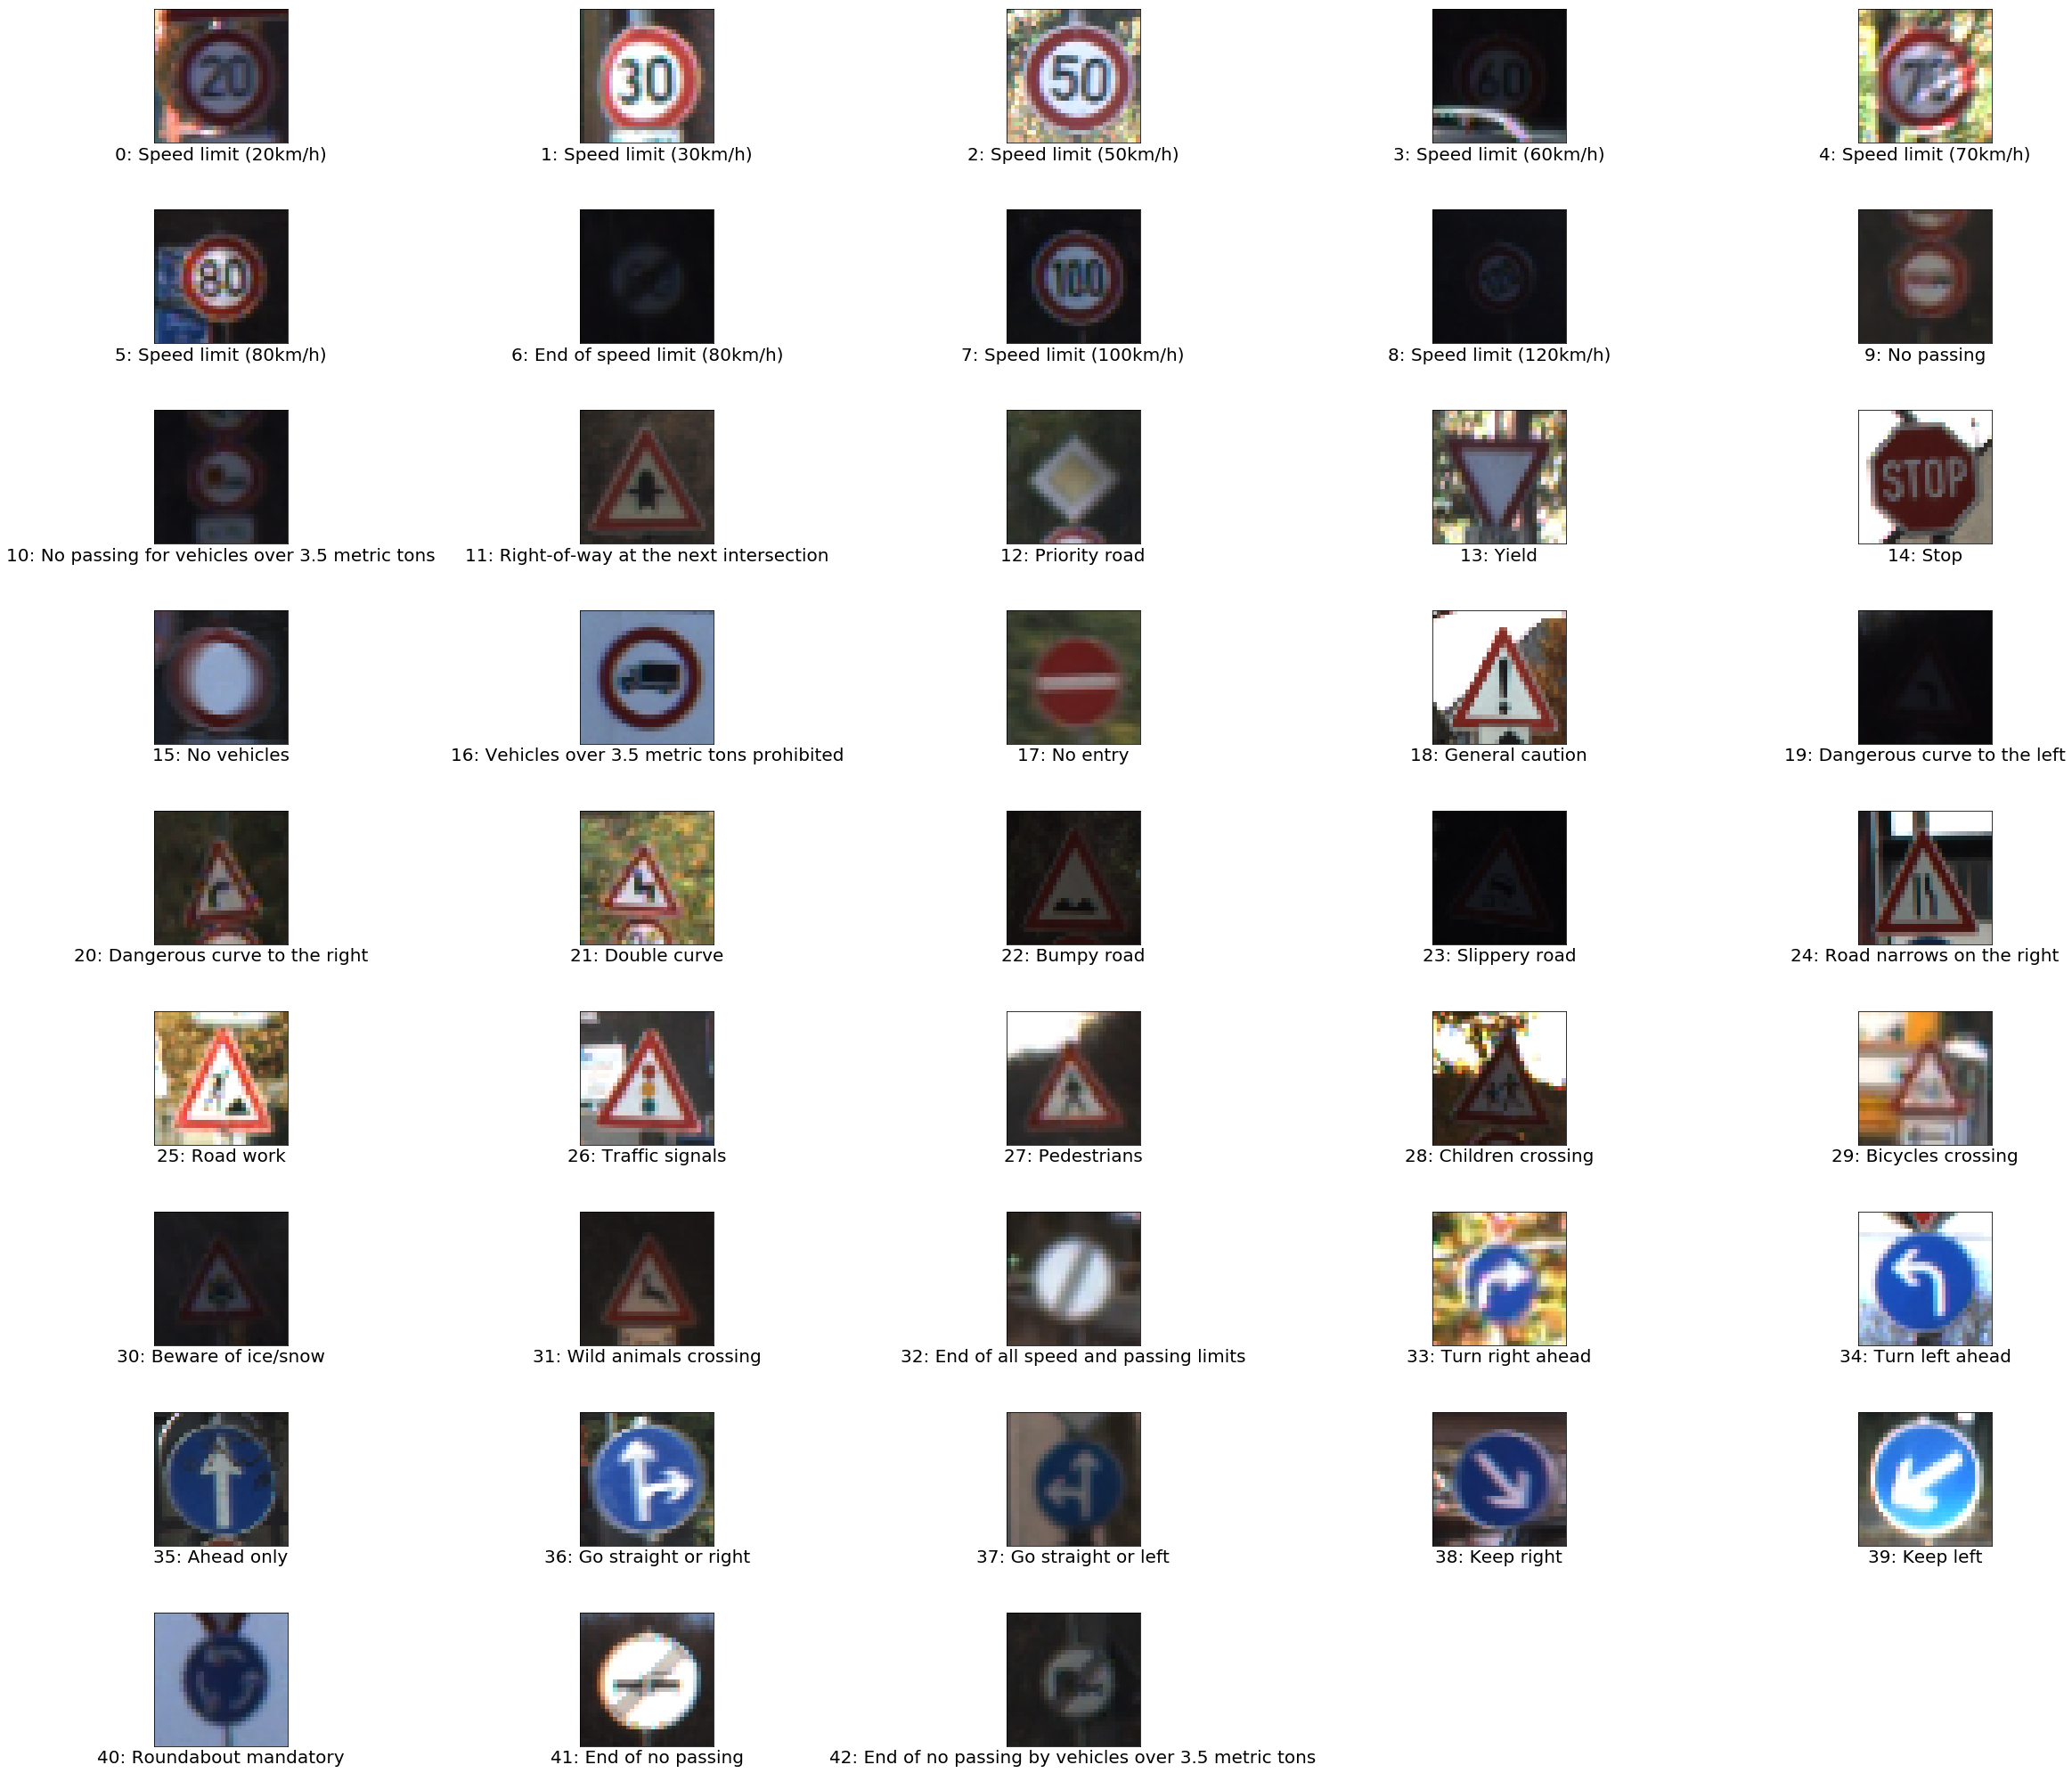

In [6]:
#now lets see each unique class Image with their corresponding Label.
display_uniques(X_test_ini)

### Number of samples per class in the train set

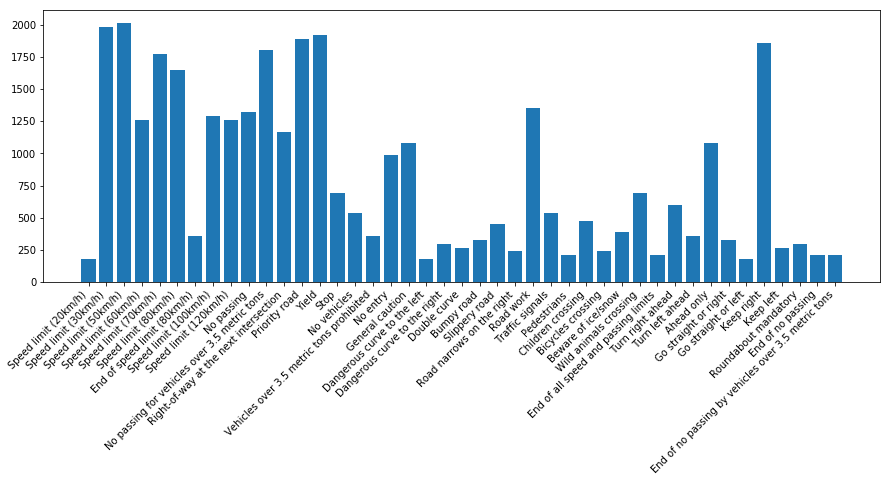

In [7]:
grouped_ds = dict()
def dataset_stats(X_train):
    stats = dict()
    for i,image in enumerate(X_train):
        if y_train[i] not in stats:
            stats[y_train[i]] = 0
            grouped_ds[y_train[i]] = []
        else:
            stats[y_train[i]] = stats[y_train[i]] + 1
            grouped_ds[y_train[i]].append(image)
    return stats
        
stats = dataset_stats(X_train_ini)
plt.figure(figsize=(15,5))
plt.bar(range(len(stats)), stats.values())
label =label_names.SignName
plt.xticks(range(len(stats)), label, ha='right', rotation=45)
plt.show()


On the chart [number of samples per class] we can see chart above that we have a considerate difference between the number of samples

## Step 2: Design and Test a Model Architecture

### Pre-process the Data Set (normalization, grayscale, etc.)

In [8]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #return tf.image.rgb_to_grayscale(img)

def normalize(img):
    """Normalize the data from 0 to 1
    """
    return img.astype(float) / 255.0

In [9]:
#Convert the image from RGB to GRAY channel
X_train_gray = []
X_test_gray = []
X_validation_gray = []

for image in X_train_ini:
    X_train_gray.append(normalize(grayscale(image)))
X_train_1 = np.array(X_train_gray).reshape((-1,32,32,1))    

for image in X_test_ini:
    X_test_gray.append(normalize(grayscale(image)))
X_test_1 = np.array(X_test_gray).reshape((-1,32,32,1))

for image in X_validation_ini:
    X_validation_gray.append(normalize(grayscale(image)))
X_validation_1 = np.array(X_validation_gray).reshape((-1,32,32,1))


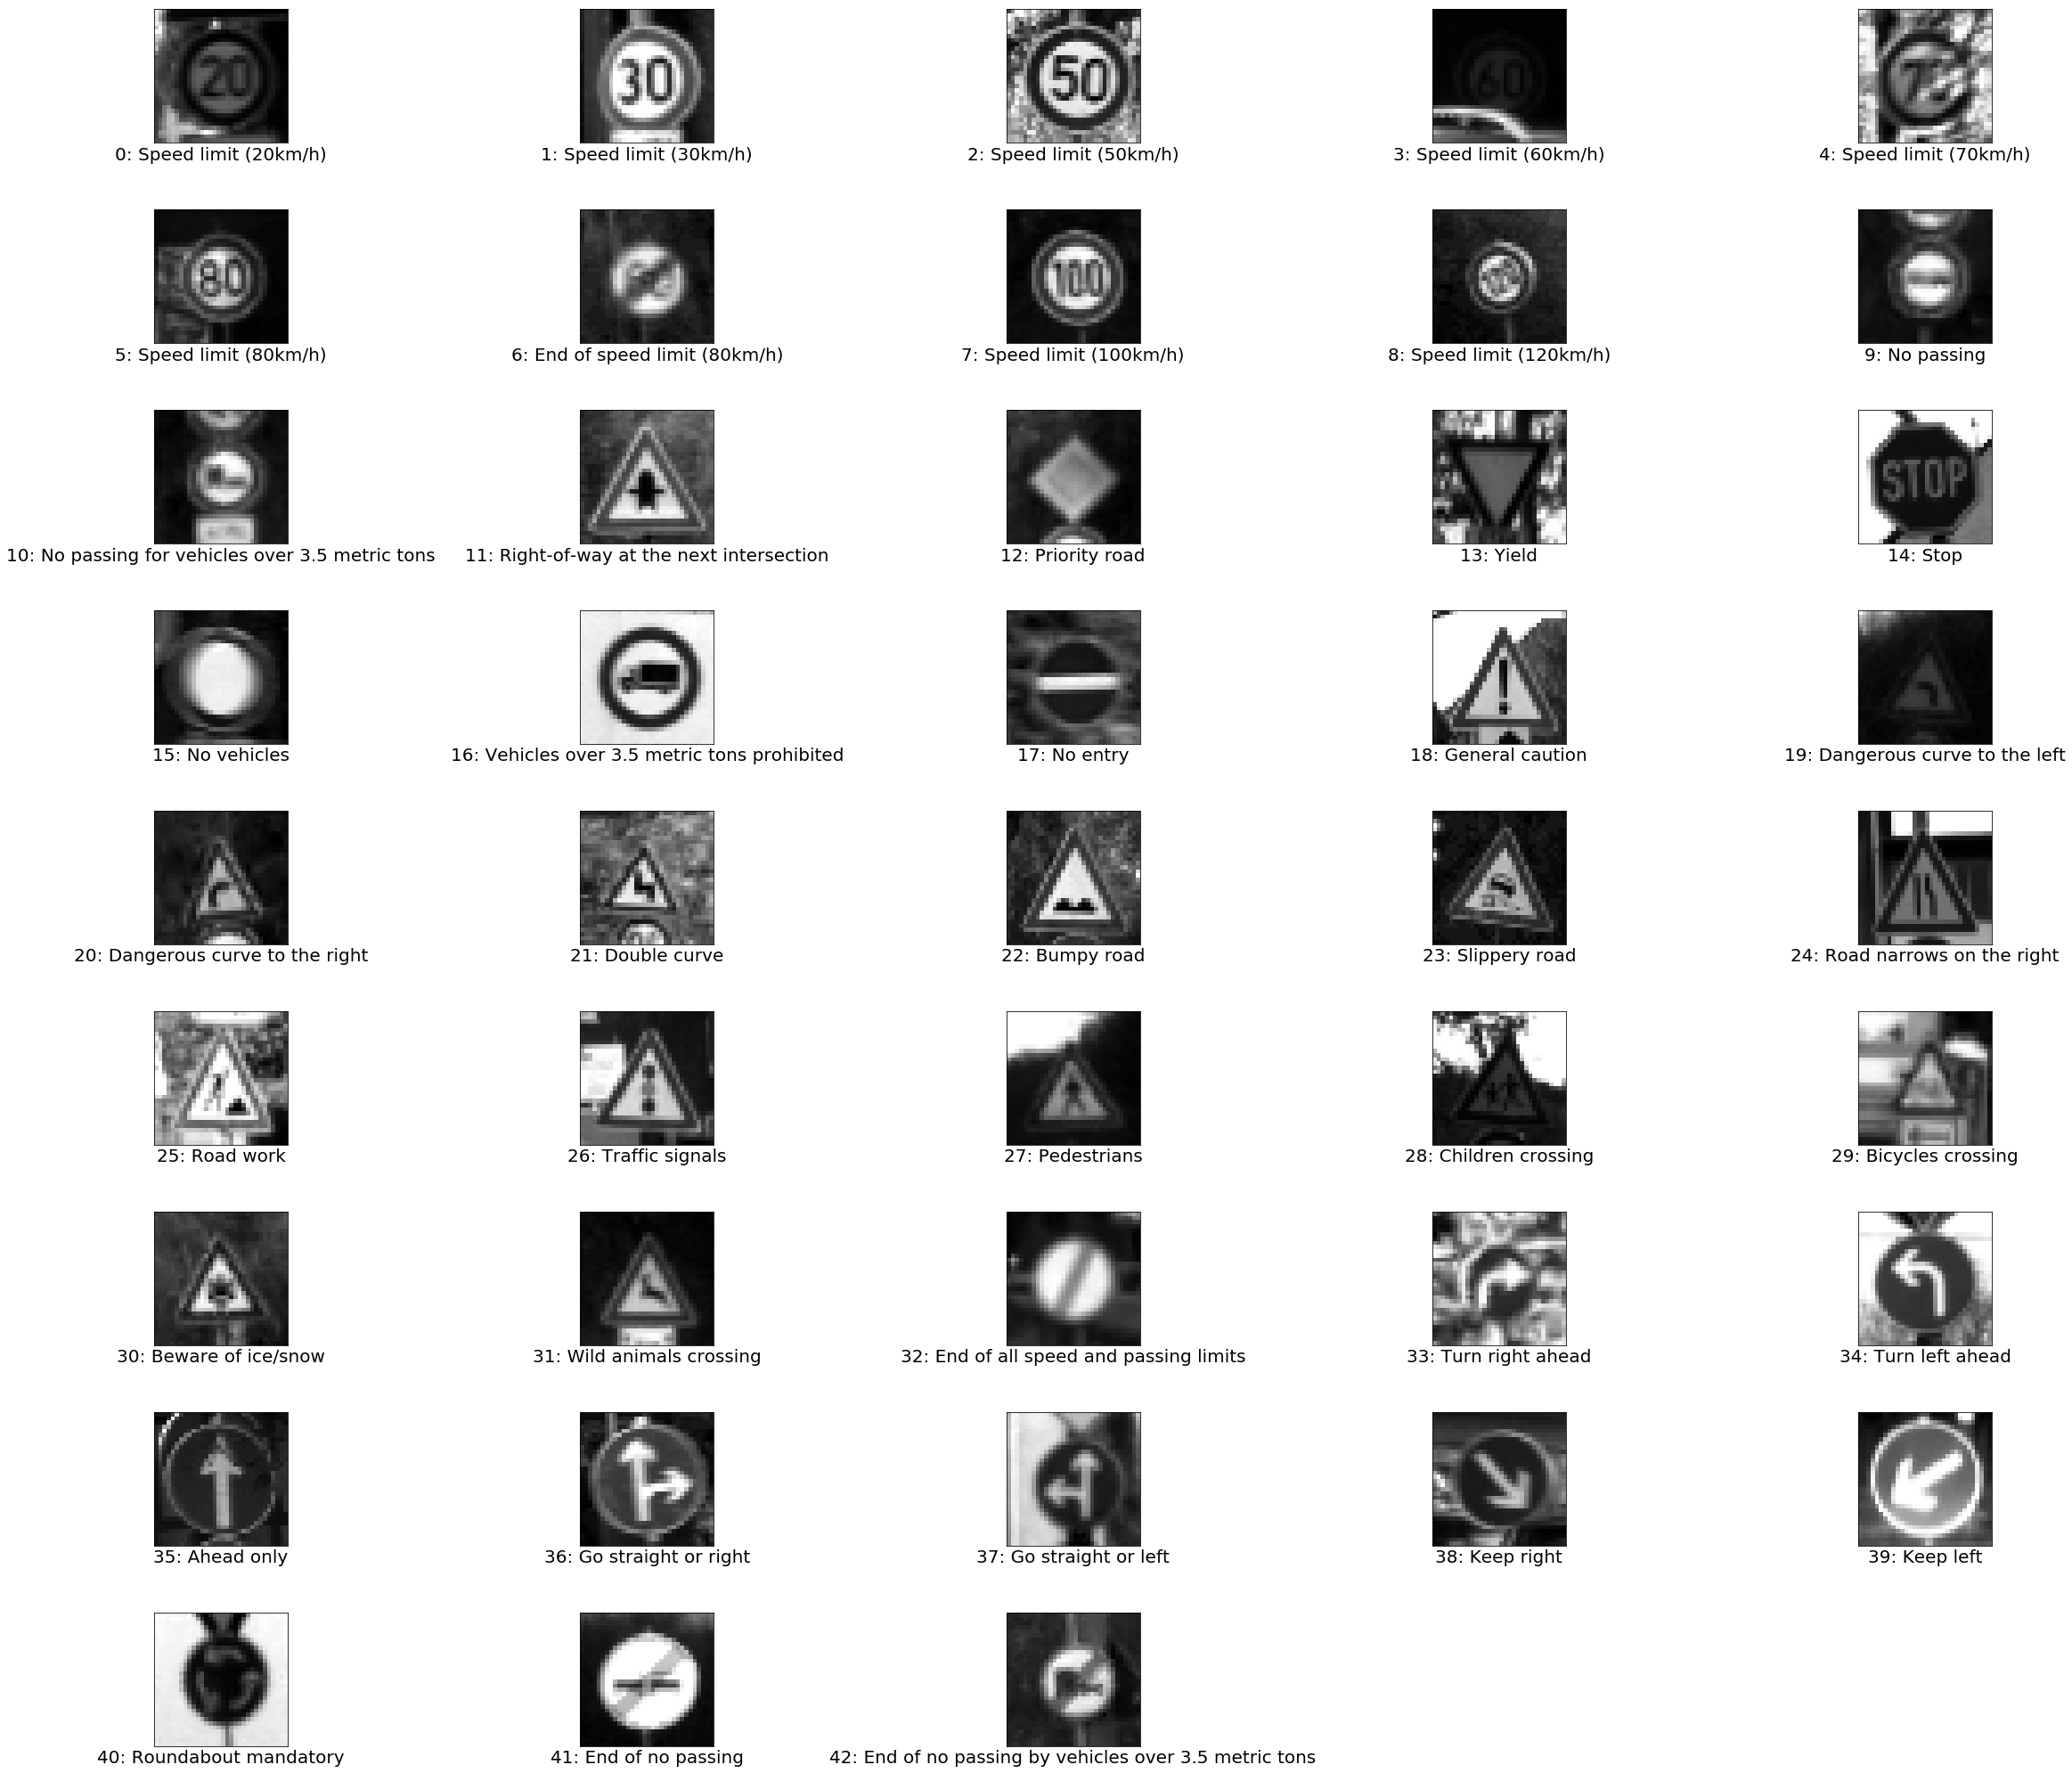

In [10]:
#now lets see each unique class Image with their corresponding Label.
display_uniques(X_test_1)

### Save processed dataset

In [11]:
prepro_dataset = {
    "features" : X_train_1,
    "labels"   : y_train
}

prepro_test_dataset = {
    "features" : X_test_1,
    "labels"   : y_test
}

prepro_validation_dataset = {
    "features" : X_validation_1,
    "labels"   : y_validation
}


file_prepro = open('processed_train.pickle', 'wb') 
pickle.dump(prepro_dataset, file_prepro, protocol=4)

file_prepro_test = open('processed_test.pickle', 'wb') 
pickle.dump(prepro_test_dataset, file_prepro_test, protocol=4)

file_prepro_validation = open('processed_validation.pickle', 'wb') 
pickle.dump(prepro_validation_dataset, file_prepro_validation, protocol=4)

## Load preprocessed dataset

In [12]:
# Load pickled data
with open("processed_train.pickle", mode='rb') as f:
    X_train_p = pickle.load(f)
with open("processed_test.pickle", mode='rb') as f:
    X_test_p = pickle.load(f)
with open("processed_validation.pickle", mode='rb') as f:
    X_validation_p = pickle.load(f)

In [13]:
X_train, y_train = X_train_p['features'], X_train_p['labels']
X_test, y_test = X_test_p['features'], X_test_p['labels']
X_validation, y_validation = X_validation_p['features'], X_validation_p['labels']

### Model Architecture

### Input
* The proposed architecture accepts a 32x32xC image as input. where C is 1 since its grayscale 

### Architecture
* **Layer 1: Convolutional.** Output shape 28x28x6.
* **Activation.** computes rectified linear.

* **Pooling.** Output shape should be 14x14x6.
* **Layer 2: Convolutional.** The output shape should be 10x10x16.
* **Activation.** Compute rectified linear.
* **Pooling.**  Output shape 5x5x16.
* **Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D.
* **Layer 3: Fully Connected.**  120 outputs.
* **Activation.** compute rectified linear.
* **Layer 4: Fully Connected.**  84 outputs.
* **Activation.** compute rectified linear.
* **Dropout.** Compute dropout.
* **Layer 5: Fully Connected (Logits).** This should have 43 outputs.
### Output
* Return the result of the last fully connected layer.


based on LeNet-5 architecture [LeNet-5](http://yann.lecun.com/exdb/lenet/) neural network architecture.

### Setup TensorFlow

In [14]:
import tensorflow as tf

EPOCHS = 100
BATCH_SIZE = 128
dropout = 0.75
C= 1
save_file = 'train_model.ckpt'

In [15]:
from tensorflow.contrib.layers import flatten

def LeNet(x, dropout):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    #Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, C, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID', name='Conv_1') + conv1_b

    #Activation.
    conv1 = tf.nn.relu(conv1)

    #Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID', name='Conv_2') + conv2_b
    
    #Activation relu
    conv2 = tf.nn.relu(conv2,name='Activ_1')

    #Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    #Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    #Activation relu
    fc1    = tf.nn.relu(fc1,name='Activ_2')

    #Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    #Activation relu
    fc2    = tf.nn.relu(fc2)

    #Activation dropout
    fc2 = tf.nn.dropout(fc2, dropout)
    
    # Layer 5: Fully Connected. Input = 84. Output = 430.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [16]:
### features
x = tf.placeholder(tf.float32, (None, 32, 32, C))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

### Train, Validate and Test the Model

In [17]:
#training pipeline
rate =0.001

logits = LeNet(x,keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits( logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)


In [18]:
#model evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()
accu = dict()
loss = dict()
def evaluate(X_data, y_data, prob):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:prob})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [19]:
#Train the model

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob : dropout })
        
        #Calculate the cost
        current_loss = sess.run(loss_operation,feed_dict={x: batch_x, y: batch_y, keep_prob : dropout})

        loss[i] = current_loss        
        validation_accuracy = evaluate(X_validation, y_validation, 1.0)
        accu[i] = validation_accuracy
        print('Epoch: {:<4} Valid Accuracy: {:<5.3} Loss: {:<8.3} '.format(i+1,validation_accuracy,current_loss))
        
    saver.save(sess, save_file)
    print("Model saved")


Training...

Epoch: 1    Valid Accuracy: 0.656 Loss: 1.19     
Epoch: 2    Valid Accuracy: 0.78  Loss: 0.689    
Epoch: 3    Valid Accuracy: 0.808 Loss: 0.484    
Epoch: 4    Valid Accuracy: 0.866 Loss: 0.385    
Epoch: 5    Valid Accuracy: 0.873 Loss: 0.283    
Epoch: 6    Valid Accuracy: 0.873 Loss: 0.27     
Epoch: 7    Valid Accuracy: 0.886 Loss: 0.213    
Epoch: 8    Valid Accuracy: 0.876 Loss: 0.202    
Epoch: 9    Valid Accuracy: 0.891 Loss: 0.222    
Epoch: 10   Valid Accuracy: 0.897 Loss: 0.163    
Epoch: 11   Valid Accuracy: 0.91  Loss: 0.129    
Epoch: 12   Valid Accuracy: 0.894 Loss: 0.0502   
Epoch: 13   Valid Accuracy: 0.89  Loss: 0.226    
Epoch: 14   Valid Accuracy: 0.895 Loss: 0.125    
Epoch: 15   Valid Accuracy: 0.898 Loss: 0.0791   
Epoch: 16   Valid Accuracy: 0.904 Loss: 0.0677   
Epoch: 17   Valid Accuracy: 0.909 Loss: 0.0901   
Epoch: 18   Valid Accuracy: 0.907 Loss: 0.0571   
Epoch: 19   Valid Accuracy: 0.919 Loss: 0.0319   
Epoch: 20   Valid Accuracy: 0.907 Los

## Visualize the model training

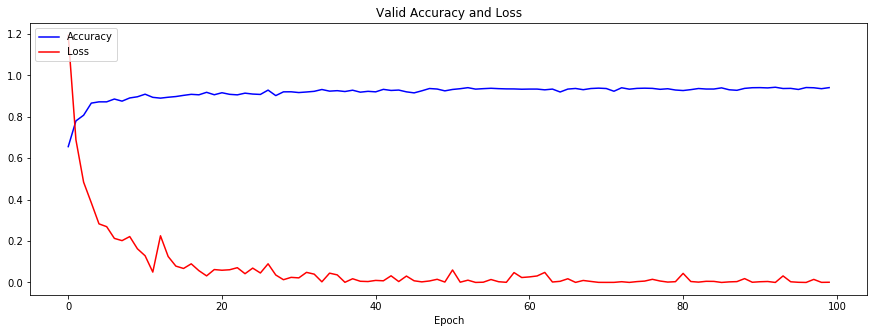

In [20]:
plt.figure(figsize=(15,5))
plt.plot(list(accu.keys()), list(accu.values()), color='b')
plt.plot(list(loss.keys()), list(loss.values()), color='r')
plt.xlabel('Epoch')
plt.title('Valid Accuracy and Loss')
plt.legend(['Accuracy', 'Loss'], loc='upper left')
plt.autoscale(enable=True, axis='both', tight=None)
plt.show()

## Evaluate The Model

In [21]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test, 1.0)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.931


## Step 3: Test a Model on New Images

### Load and Output the Images

In [22]:
import glob
import cv2
extra_images = glob.glob('*.jpg')

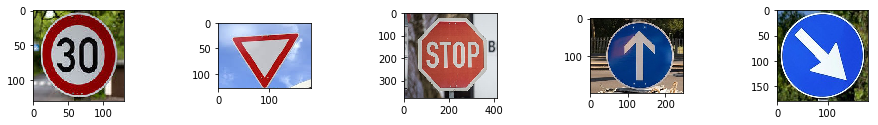

In [23]:
#now lets see each unique class Image with their corresponding Label.
pylab.rcParams['figure.figsize'] = (15, 15)

for i, image in enumerate(extra_images):
    plt.subplot(5,5,i+1)
    img=plt.imread(image)
    plt.subplots_adjust(hspace=1, wspace=1)
    plt.imshow(img)
plt.show()

### Resize images

In [24]:
# Read sample image files, resize them, convert to numpy arrays w/ dtype=uint8
image_files  = glob.glob('*.jpg') 
new_X = []
for image_file in image_files:
    image = Image.open(image_file)
    image = image.convert('RGB')
    image = image.resize((32, 32), Image.ANTIALIAS)
    image = np.array(list(image.getdata()), dtype='uint8')
    image = np.reshape(image, (32, 32, 3))
    new_X.append(image)
new_X = np.array(new_X, dtype='uint8')

In [25]:
gray=[]
for image in new_X:
    gray.append(normalize(grayscale(image)))
new_X_gray = np.array(gray).reshape((-1,32,32,1))    


In [26]:
#new_X_gray_labels =['14','15','2','35','36']
new_X_gray_labels = []
for file in image_files:
    new_X_gray_labels.append(os.path.splitext(file)[0])

### Predict the Sign Type for Each Image and Analyze performance

In [52]:
classify_operation = tf.argmax(logits, 1)
soft = tf.nn.softmax(logits)
new_y = np.zeros(n_classes)

with tf.Session() as sess:
    saver.restore(sess,  tf.train.latest_checkpoint('.'))
    index = sess.run(classify_operation, feed_dict={x: new_X_gray, y: new_X_gray_labels, keep_prob: 1.0})
    
    res = sess.run(correct_prediction, feed_dict={x : new_X_gray, y : new_X_gray_labels, keep_prob : 1.0})
    test_accuracy = evaluate(new_X_gray,  new_X_gray_labels, 1.0)
    
    print("Accuracy {:.3f}".format(test_accuracy))
    print("Prediction {}".format(res))
    print(image_files)
    print(index)

Accuracy 1.000
Prediction [ True  True  True  True  True]
['1.jpg', '13.jpg', '14.jpg', '35.jpg', '38.jpg']
[ 1 13 14 35 38]


#### this model has 100% accuracy on new images

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). 

### The top five softmax probabilities for the predictions on the German traffic sign images found on the web. 


In [80]:
#classify_operation = tf.argmax(logits, 1)
soft = tf.nn.softmax(logits)
new_y = np.zeros(n_classes)
top_K = tf.nn.top_k(soft,5)

with tf.Session() as sess:
    saver.restore(sess,  tf.train.latest_checkpoint('.'))
    res = sess.run(correct_prediction, feed_dict={x : new_X_gray, y : new_X_gray_labels, keep_prob : 1.0})
    probs, preds = sess.run(top_K, feed_dict={x : new_X_gray, y : new_X_gray_labels, keep_prob : 1.0})
    test_accuracy = evaluate(new_X_gray,  new_X_gray_labels, 1.0)

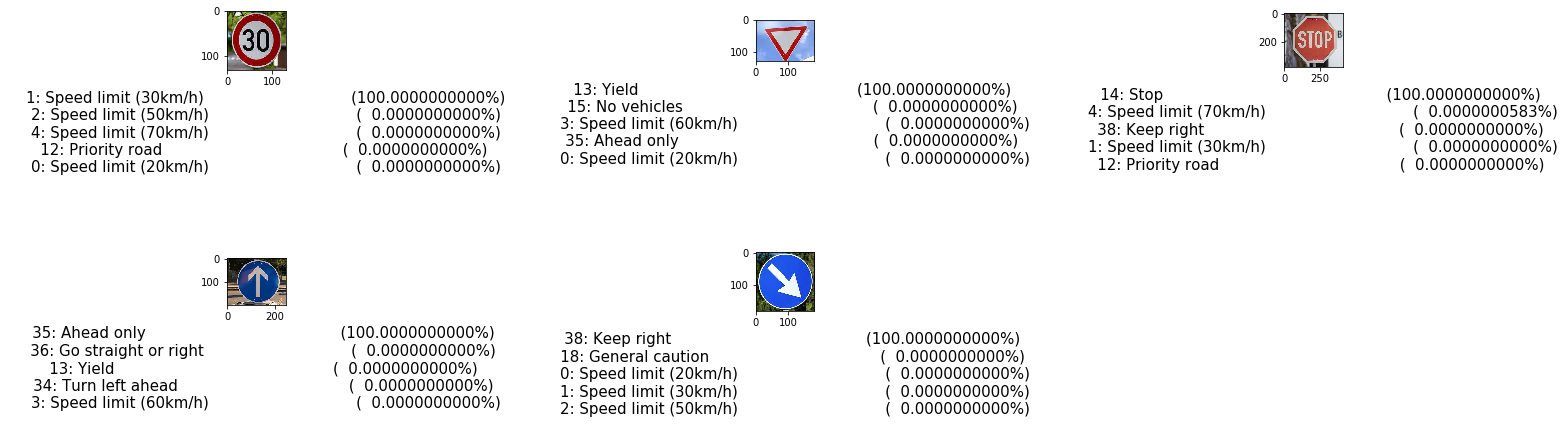

In [90]:
pylab.rcParams['figure.figsize'] = (20, 20)
for i, image in enumerate(extra_images):
    plt.subplot(5,3,i+1)
    img=plt.imread(image)
    plt.subplots_adjust(hspace=1, wspace=8)
    plt.imshow(img)
    legend=[]
    for  prd, prb in zip(preds[i].astype(int), probs[i]):
        sign_name = label_names.SignName[prd]
        leg=('{:>5}: {:<50} ({:>14.10f}%)'.format(prd, sign_name, prb*100.0))
        legend.append(leg)
    str1 = '\n'.join(legend)
    plt.xlabel(str1,fontsize=15)
    
plt.show()

---

## Step 4: Visualize the Neural Network's State with Test Images

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. 


### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

* image_input: the test image being fed into the network to produce the feature maps
* tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
* activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
* plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry


In [91]:
def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1,session=tf.get_default_session()):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

### Visualize

In [92]:
index_1 = tf.placeholder(tf.int32, (None))

In [93]:
sess= tf.Session()
sess.run(tf.global_variables_initializer())

34777
38


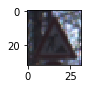

In [94]:
index_1 = random.randint(0, len(X_train_ini))
print(index_1)
image = X_train_ini[index_1].squeeze()
plt.figure(figsize=(1,1))
plt.imshow(image)
print(y_train[index_1])

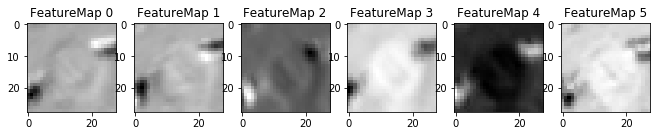

In [95]:
layer_to_show = sess.graph.get_tensor_by_name('Conv_1:0')
outputFeatureMap([X_train[index_1]], layer_to_show, session=sess)

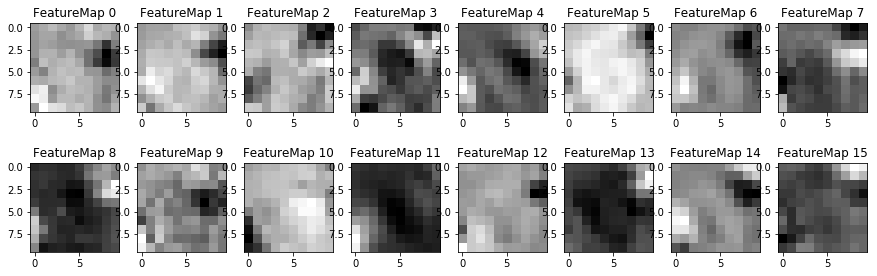

In [96]:
layer_to_show = sess.graph.get_tensor_by_name('Conv_2:0')
outputFeatureMap([X_train[index_1]], layer_to_show, session=sess)

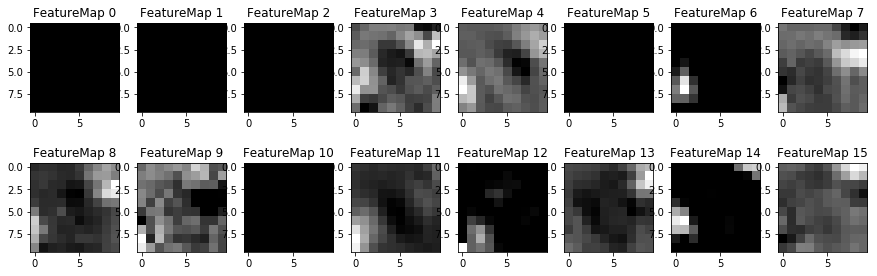

In [97]:
layer_to_show = sess.graph.get_tensor_by_name('Activ_1:0')
outputFeatureMap([X_train[index_1]], layer_to_show, session=sess)

In [98]:
sess.close()

### Question 9

Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 